In [1]:
#%pip install pandas numpy matplotlib seaborn scikit-learn torch prometheus_client prometheus_api prometheus-api-client tsts

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from itertools import product

from prometheus_api_client import PrometheusConnect
from prometheus_api_client.metric_range_df import MetricRangeDataFrame
from prometheus_api_client.utils import parse_datetime

import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
#from tsts.models import Transformer
#from tsts.utils import TimeSeriesTensor

import torch
import torch.nn as nn
import torch.optim as optim

In [35]:
# Importar bibliotecas necessárias
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.dates as mdates

# Carregar o dataset e manter o índice de datas
file_path = '../../data/ts.pkl'  # Caminho do arquivo ts.pkl
df = pd.read_pickle(file_path)
df = df['value'].astype(float).resample('5min').mean().ffill()  # Reamostragem para 1 minuto e preenchimento
dates = df.index  # Preservar as datas originais

# Padronizar os dados
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df.values.reshape(-1, 1))

# Criar sequências e associar datas aos alvos
SEQ_LENGTH = 60
X, y, y_dates = [], [], []
for i in range(len(df_scaled) - SEQ_LENGTH):
    X.append(df_scaled[i:i + SEQ_LENGTH])  # Sequências de entrada
    y.append(df_scaled[i + SEQ_LENGTH])   # Valores alvo
    y_dates.append(dates[i + SEQ_LENGTH]) # Datas correspondentes aos alvos

X = np.array(X)
y = np.array(y)
y_dates = np.array(y_dates)

# Expandir a dimensão para corresponder a 'd_model'
d_model = 64
X = np.repeat(X, d_model, axis=2)

# Dividir em treino e teste, incluindo as datas
X_train, X_test, y_train, y_test, y_dates_train, y_dates_test = train_test_split(
    X, y, y_dates, test_size=0.2, random_state=42
)

# Converter para tensores PyTorch
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [38]:
# Define the Transformer Encoder model
class Encoder(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_layers, dim_feedforward):
        super(Encoder, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.linear_out = nn.Linear(d_model, 1)

    def forward(self, src):
        src = src.permute(1, 0, 2)
        output = self.transformer_encoder(src)
        output = self.linear_out(output[-1])
        return output

# Hyperparameters to tune
learning_rates = [0.001, 0.01]
num_layers_list = [2, 3]

# Other fixed hyperparameters
input_dim = d_model
nhead = 4
dim_feedforward = 256
batch_size = 64
num_epochs = 10

# Function to run the training loop for a given set of hyperparameters
def train_model(learning_rate, num_layers):
    # Initialize model, loss, and optimizer with the given hyperparameters
    model = Encoder(input_dim, d_model, nhead, num_layers, dim_feedforward)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        for i in range(0, len(X_train), batch_size):
            X_batch = X_train[i:i + batch_size]
            y_batch = y_train[i:i + batch_size]
            
            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
    return model

# Initialize the best MAE and RMSE to infinity and the best hyperparameters to None
best_mae = float('inf')
best_rmse = float('inf')
best_hyperparams = None
best_model = None

# Grid search
for learning_rate, num_layers in product(learning_rates, num_layers_list):
    model = train_model(learning_rate, num_layers)
    
    # Evaluate the model
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test)
    
    # Rescale the predicted values
    y_pred_rescaled = scaler.inverse_transform(y_pred)
    y_test_rescaled = scaler.inverse_transform(y_test)
    
    # Calculate evaluation metrics
    mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
    rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
    
    print(f'Learning Rate: {learning_rate}, Num Layers: {num_layers}, MAE: {mae}, RMSE: {rmse}')
    
    # Update the best MAE and RMSE and best hyperparameters if needed
    if mae < best_mae:
        best_mae = mae
        best_rmse = rmse
        best_hyperparams = {'learning_rate': learning_rate, 'num_layers': num_layers}
        best_model = model

print(f'Best Hyperparameters: {best_hyperparams}, Best MAE: {best_mae}, Best RMSE: {best_rmse}')


/Users/wrosalem/Documents/0x0-Coding/GitHub/dissertacao/Experiments/src/2025/.venv/lib/python3.11/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Learning Rate: 0.001, Num Layers: 2, MAE: 16016071.998755172, RMSE: 29420284.05764433


/Users/wrosalem/Documents/0x0-Coding/GitHub/dissertacao/Experiments/src/2025/.venv/lib/python3.11/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Learning Rate: 0.001, Num Layers: 3, MAE: 20510597.049331598, RMSE: 32601004.300952435


/Users/wrosalem/Documents/0x0-Coding/GitHub/dissertacao/Experiments/src/2025/.venv/lib/python3.11/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Learning Rate: 0.01, Num Layers: 2, MAE: 34130153.6267106, RMSE: 45135845.11688839


/Users/wrosalem/Documents/0x0-Coding/GitHub/dissertacao/Experiments/src/2025/.venv/lib/python3.11/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Learning Rate: 0.01, Num Layers: 3, MAE: 31801780.984073747, RMSE: 43102472.669119194
Best Hyperparameters: {'learning_rate': 0.001, 'num_layers': 2}, Best MAE: 16016071.998755172, Best RMSE: 29420284.05764433


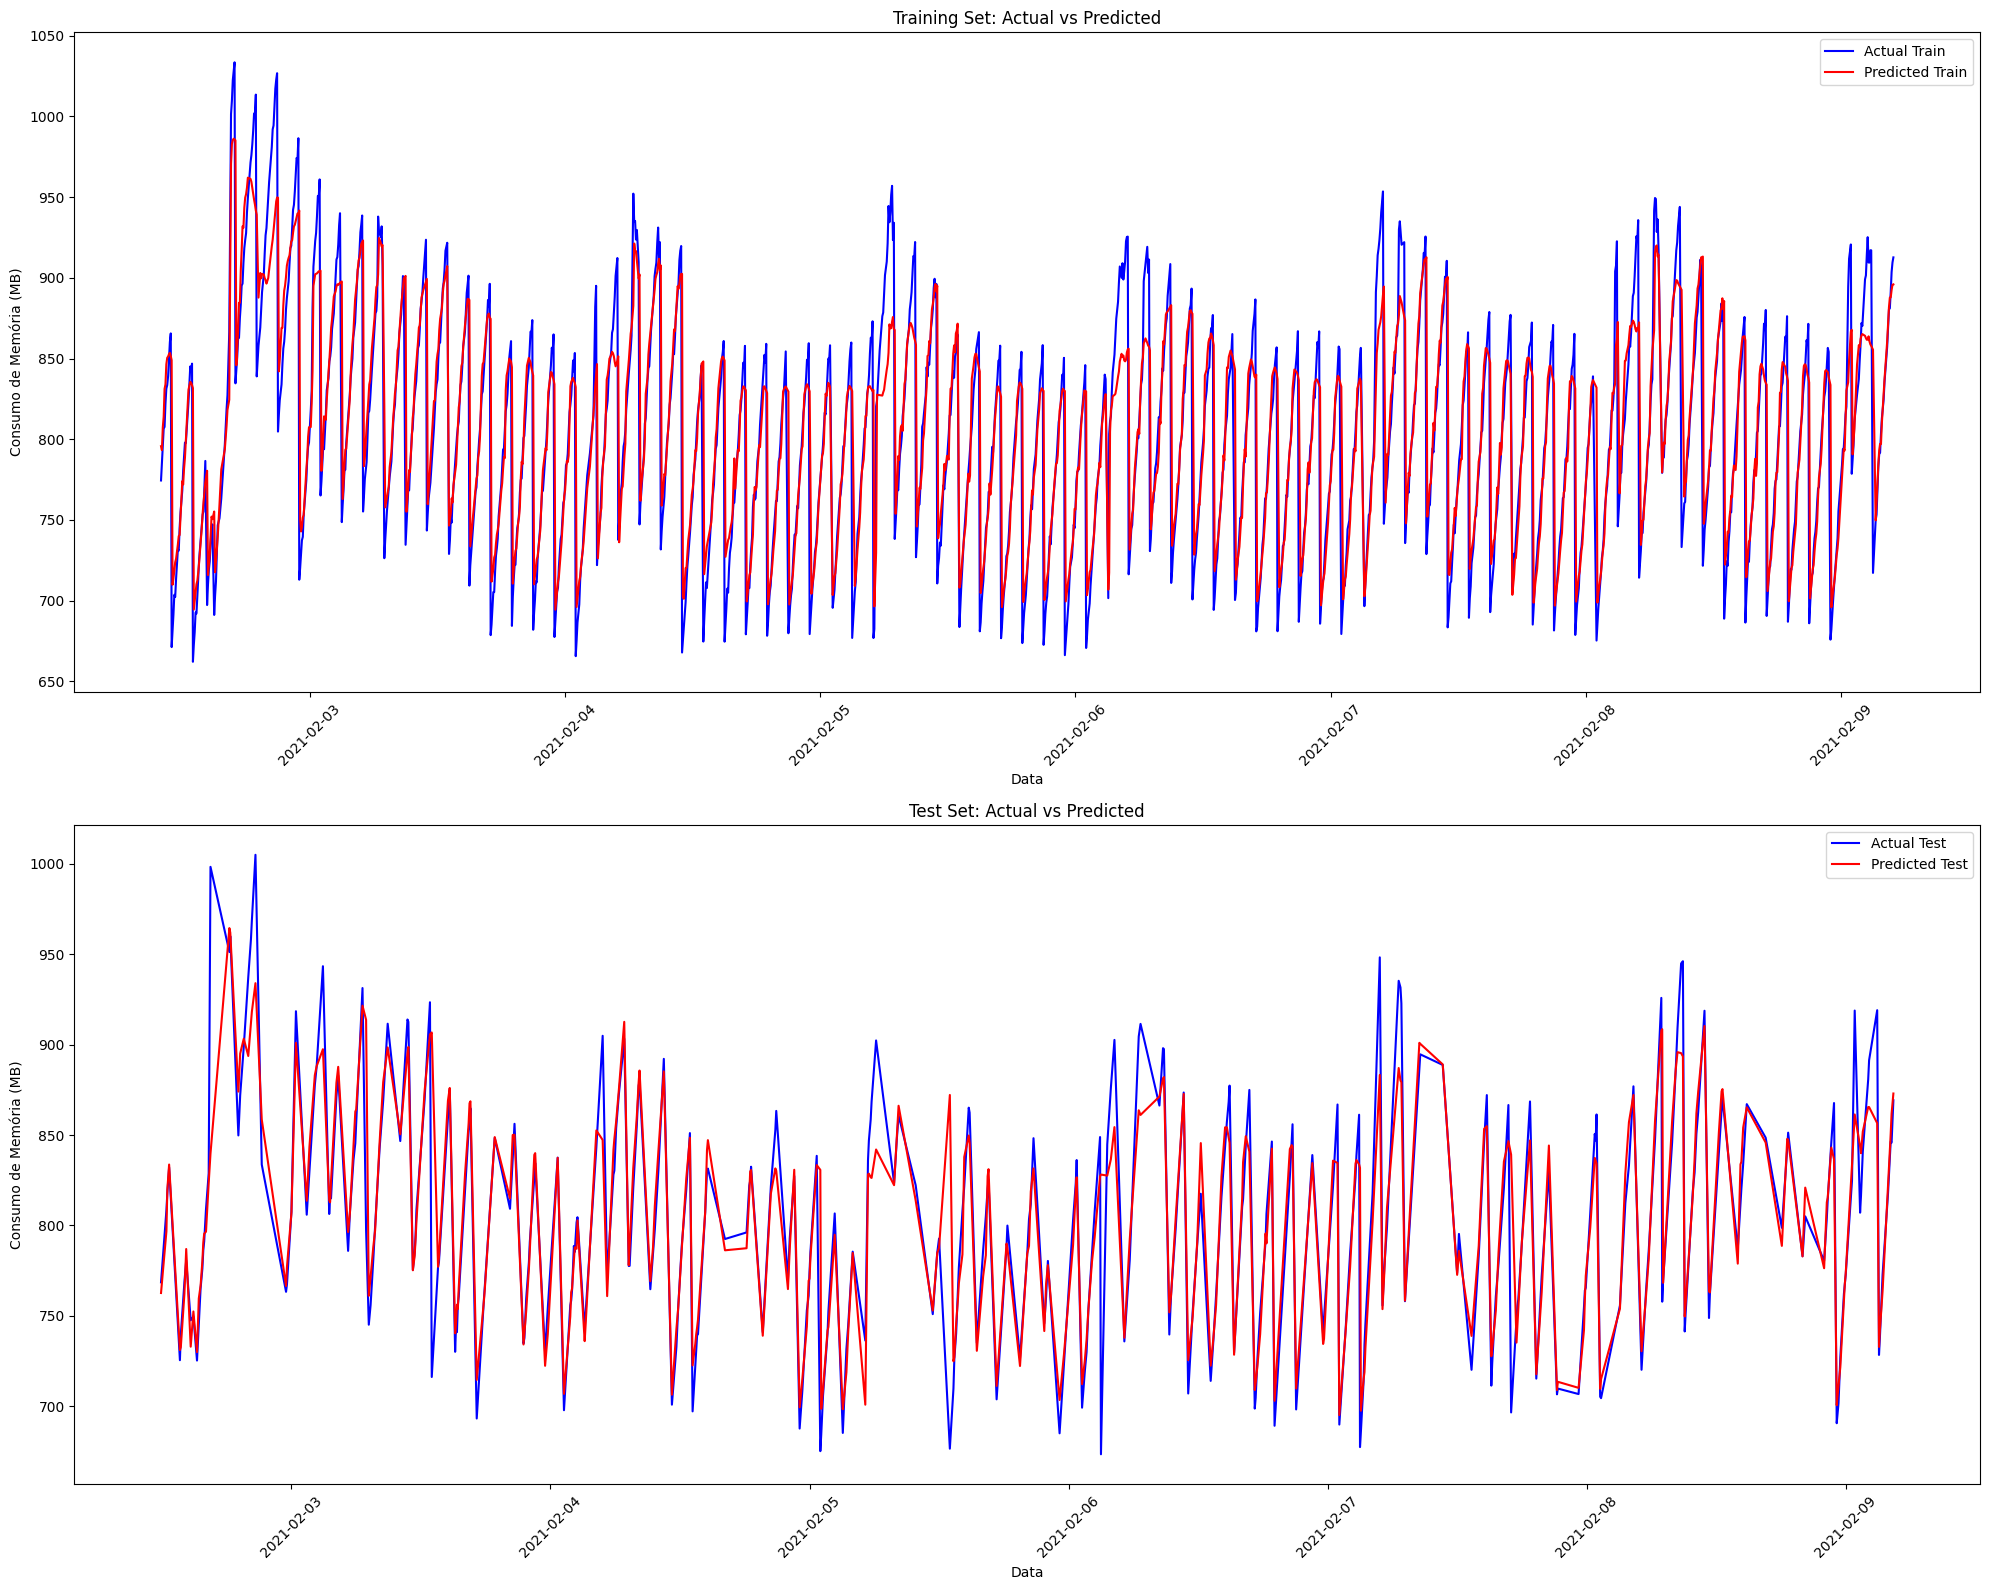

In [37]:
# Plotting
# Fazer previsões com o melhor modelo
model = best_model
model.eval()

# Previsões no conjunto de treino
with torch.no_grad():
    y_train_pred = model(X_train)
y_train_pred_original = scaler.inverse_transform(y_train_pred.numpy())  # Reverter padronização
y_train_original = scaler.inverse_transform(y_train.numpy())           # Valores reais

# Converter para MB (assumindo que os valores originais estão em bytes)
y_train_pred_mb = y_train_pred_original / (1024 ** 2)
y_train_mb = y_train_original / (1024 ** 2)

# Previsões no conjunto de teste
with torch.no_grad():
    y_test_pred = model(X_test)
y_test_pred_original = scaler.inverse_transform(y_test_pred.numpy())
y_test_original = scaler.inverse_transform(y_test.numpy())

y_test_pred_mb = y_test_pred_original / (1024 ** 2)
y_test_mb = y_test_original / (1024 ** 2)

# Criar DataFrames para ordenar por data
train_df = pd.DataFrame({
    'date': y_dates_train,
    'actual': y_train_mb.flatten(),
    'predicted': y_train_pred_mb.flatten()
})
train_df = train_df.sort_values('date')  # Ordenar cronologicamente

test_df = pd.DataFrame({
    'date': y_dates_test,
    'actual': y_test_mb.flatten(),
    'predicted': y_test_pred_mb.flatten()
})
test_df = test_df.sort_values('date')  # Ordenar cronologicamente

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Criar subplots com tamanho maior
fig, ax = plt.subplots(2, 1, figsize=(20, 16))

# Plotar o conjunto de treino
ax[0].plot(train_df['date'], train_df['actual'], label='Actual Train', color='blue')
ax[0].plot(train_df['date'], train_df['predicted'], label='Predicted Train', color='red')
ax[0].set_title('Training Set: Actual vs Predicted')
ax[0].set_xlabel('Data')
ax[0].set_ylabel('Consumo de Memória (MB)')
ax[0].legend()

# Plotar o conjunto de teste
ax[1].plot(test_df['date'], test_df['actual'], label='Actual Test', color='blue')
ax[1].plot(test_df['date'], test_df['predicted'], label='Predicted Test', color='red')
ax[1].set_title('Test Set: Actual vs Predicted')
ax[1].set_xlabel('Data')
ax[1].set_ylabel('Consumo de Memória (MB)')
ax[1].legend()

# Formatar o eixo x para melhor legibilidade das datas
for axis in ax:
    axis.xaxis.set_major_locator(mdates.DayLocator())  # Mostrar marcas por dia
    axis.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Formato da data
    axis.tick_params(axis='x', rotation=45)  # Rotacionar rótulos para evitar sobreposição

# Ajustar o layout para evitar sobreposição
plt.tight_layout()

# Salvar a figura com 300 DPI
plt.savefig('plot_consumo_memoria.png', dpi=300)

# Exibir o gráfico
plt.show()